## This Notebook runs all necessary scenarios and output collections for figure 3 and constructs figure 3

In [1]:
# Import all things necessary
from scenario_class import Scenario
from plots_class import Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import matplotlib.cm as cm
from scenariosweeper_class import ScenarioSweeper
import matplotlib.gridspec as gridspec

this is the cumulative emissions  before cdr adjustment 1187278323149.1287
this is the cumulative emissions  after cdr adjustment 889778323149.1285
this is the cumulative emissions  before cdr adjustment 1625296659134.382
this is the cumulative emissions  after cdr adjustment 1327796659134.382
this is the cumulative emissions  before cdr adjustment 1977032789673.608
this is the cumulative emissions  after cdr adjustment 1679532789673.608
this is the cumulative emissions  before cdr adjustment 2283776831716.332
this is the cumulative emissions  after cdr adjustment 1986276831716.3323
this is the cumulative emissions  before cdr adjustment 2561498290153.173
this is the cumulative emissions  after cdr adjustment 2263998290153.173
this is the cumulative emissions  before cdr adjustment 2818411142107.1196
this is the cumulative emissions  after cdr adjustment 2520911142107.1196
this is the cumulative emissions  before cdr adjustment 1199382844938.7522
this is the cumulative emissions  after

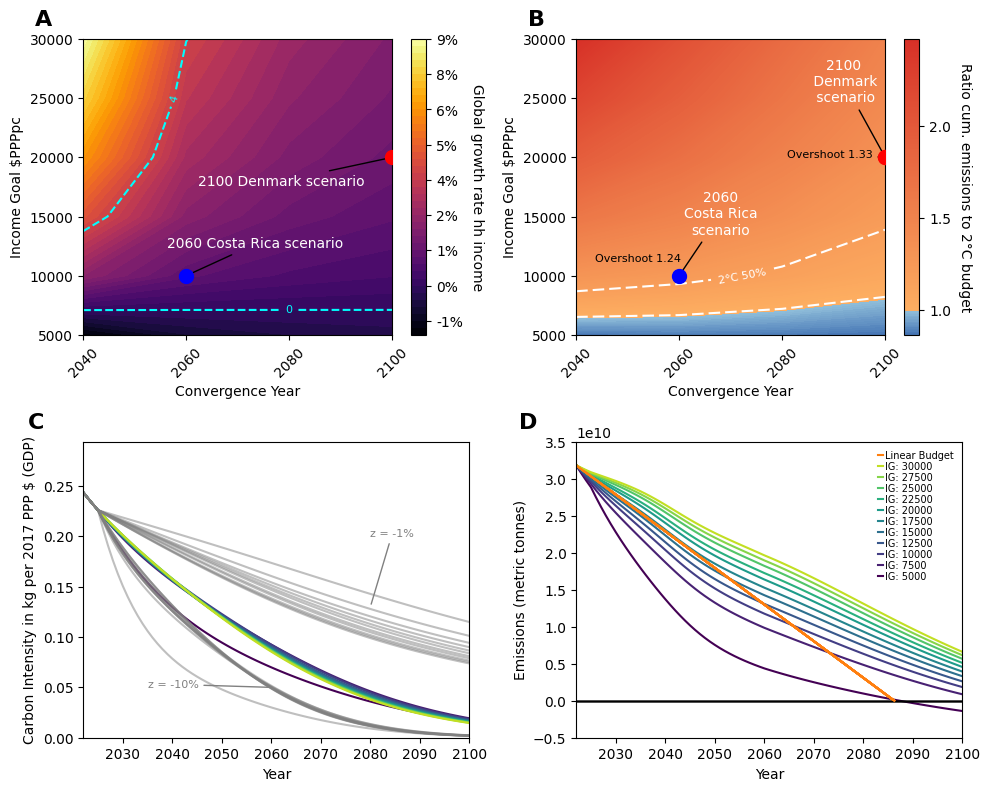

In [ ]:
# Create a figure
fig = plt.figure(figsize=(10, 8))

# Define a GridSpec for a 2x2 grid
gs = gridspec.GridSpec(2, 2, figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[0, 1])  # Top-right
ax3 = fig.add_subplot(gs[1, 0])  # Bottom-left
ax4 = fig.add_subplot(gs[1, 1])  # Bottom-right


# calculate how much emissions are emitted in a given scenario run and how far above this is the carbon budget by summing the yearly emissions of all countries
# Example usage:
end_year_values = [2040, 2060, 2080, 2100]
income_goal_values = [5000, 10000, 15000, 20000, 25000, 30000]
carbon_budget_values = [1150*0.95 - 2*35] # 95% of the carbon budget because of 95% population coverage and minus two years because first model year is 2023 and the budgets are from 2020 onwards
#hysteresis_tech_progress_values = [0.01] # this is a growth rate, so between 0 and 1, which only applies if tech_hysteresis_assumption is on
gdp_assumption_values = ["constant_ratio"]
pop_growth_assumption_values = ["semi_log_model"]
tech_evolution_assumption_values = ["plausible"]
tech_hysteresis_assumption_values = ["on"]
steady_state_high_income_assumption_values = ["off"]
population_hysteresis_assumption_values = ["on"]
sigmoid_parameters = [0.05, 2060] # k, first param., is the steepness of the sigmoid (0 < k < 1) and t0, second param, is the year of the midpoint of the sigmoid function of the weighted
final_improvement_rate = [-0.05] # final global uniform carbon intensity improvement rate that countries transition to from green growth trend which is the best rate that is currently grasped by the fit more or less
run_until_2100 = ["on"] # this is a string and either (1) on or (2) off for details see the scenario_class.py file
cdr_assumption = ["on"] # this is a string and either (1) on or (2) off for details see the scenario_class.py file
cdr_level_2100 = [5] #  in gigatons of CO2 per year, so 0.95 means 950 million tons of CO2 per year



sweeper1 = ScenarioSweeper(end_year_values,
                           income_goal_values,
                           carbon_budget_values,
                           gdp_assumption_values,
                           pop_growth_assumption_values,
                           tech_evolution_assumption_values,
                           tech_hysteresis_assumption_values,
                           steady_state_high_income_assumption_values,
                           sigmoid_parameters,
                           final_improvement_rate,
                           population_hysteresis_assumption_values,
                           run_until_2100,
                           cdr_assumption,
                           cdr_level_2100)


output = sweeper1.run_scenarios() 
# output[0] is the emissions and output[1] is the gdp growth rate globally
input1 = output[0] # this output is total emissions. output now will be transformed to an input for the plots function
input2 = output[1] # this output is avg global growth rate. output now will be transformed to an input for the plots function
# Create a new figure with four axes
sweeper1.plot_total_emissions_trade_off(input1, ["end_year", "income_goal"], ax = ax2, fixed_color_scale=False, annotations_plot = True, colorscaleon = True)
sweeper1.plot_growth_rate_trade_off(input2, ["end_year", "income_goal"], ax1)

# ax two color bar colorbar ticklabels only at 0.5, 1, 1.5 and 2
cbar = ax2.collections[0].colorbar
cbar.set_ticks([1, 1.5, 2])

# create a list of income goals
income_goals = [5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000]

# create colormap and map to income goals
colors = cm.viridis([i/len(income_goals) for i in range(len(income_goals))])    

ci_data = list()
# Plot global emissions pathways
for income_goal in income_goals:
    scenario_params = {
        "end_year": 2100,
        "income_goal": income_goal,
        "carbon_budget": 1150*0.95 - 2*35, # 95% of the carbon budget because of 95% population coverage and minus two years because first model year is 2023 and the budgets are from 2020 onwards
        #"hysteresis_tech_progress": 0.01, # this is a growth rate, so between 0 and 1, which only applies if tech_hysteresis_assumption is on
        "gdp_assumption": "constant_ratio",
        "pop_growth_assumption": "semi_log_model",
        "tech_evolution_assumption": "plausible",
        "tech_hysteresis_assumption": "on", # turn off tech hysteresis for this plot
        "steady_state_high_income_assumption": "off",
        "k": sigmoid_parameters[0],
        "t0": sigmoid_parameters[1],
        "final_improvement_rate": final_improvement_rate[0],
        "population_hysteresis_assumption": "on",
        "run_until_2100": run_until_2100[0], # this is a string and either (1) on or (2) off for details see the scenario_class.py file
        "cdr_assumption": cdr_assumption[0], # this is a string and either (1) on or (2) off for details see the scenario_class.py file 
        "cdr_level_2100": cdr_level_2100[0] #  in gigatons of CO2 per year, so 0.95 means 950 million tons of CO2 per year
    }

    scenario_1 = Scenario(scenario_params)
    scenario_1.compute_country_scenario_params()
    scenario_1.run()
    plotting_1 = Plots(scenario_1)
    # Plot the results
    plotting_1.plot_global_emissions(ax=ax4,
                                    color=colors[income_goals.index(income_goal)],
                                    label="IG: " + str(income_goal))
    # Plot the results
    ci_data_current = plotting_1.plot_global_carbon_intensity(ax=ax3,
                                            color=colors[income_goals.index(income_goal)],
                                            label="income goal: " + str(income_goal))
    ci_data.append(ci_data_current)


# Collect all legend handles and labels for global emissions pathways
handles1, labels1 = ax4.get_legend_handles_labels()

# Find unique labels and their handles, maintaining original order
unique_labels_handles1 = dict()
for label, handle in zip(labels1, handles1):
    if label not in unique_labels_handles1:
        unique_labels_handles1[label] = handle

# Prepare lists for sorted labels and their corresponding handles
sorted_labels1 = []
sorted_handles1 = []

# Add the "Linear Carbon Budget Pathway" first if it exists
if "Linear Budget" in unique_labels_handles1:
    sorted_labels1.append("Linear Budget")
    sorted_handles1.append(unique_labels_handles1["Linear Budget"])

# Process and sort income goal labels in descending order
income_goals_labels1 = [(label, handle) for label, handle in unique_labels_handles1.items() if label.startswith("IG: ")]
# Sort based on the integer value extracted from the label
income_goals_labels1.sort(key=lambda x: int(x[0].split(": ")[1]), reverse=True)

# Append sorted income goal labels and their handles
sorted_labels1 += [label for label, _ in income_goals_labels1]
sorted_handles1 += [handle for _, handle in income_goals_labels1]

# Create the legend for global emissions pathways
ax4.legend(sorted_handles1, sorted_labels1, frameon=False, loc='upper right', fontsize=7,
           handlelength=0.5, handletextpad=0.2, labelspacing=0.1)

# Set y-axis limit for global emissions pathways
ax4.set_ylim(0.5*-1e10, 3.5*1e10)

# Collect all legend handles and labels for carbon intensity pathways
handles2, labels2 = ax1.get_legend_handles_labels()

# Find unique labels and their handles, maintaining original order
unique_labels_handles2 = dict()
for label, handle in zip(labels2, handles2):
    if label not in unique_labels_handles2:
        unique_labels_handles2[label] = handle

# Prepare lists for sorted labels and their corresponding handles
sorted_labels2 = []
sorted_handles2 = []

# Process and sort income goal labels in descending order
income_goals_labels2 = [(label, handle) for label, handle in unique_labels_handles2.items() if label.startswith("income goal")]
# Sort based on the integer value extracted from the label
income_goals_labels2.sort(key=lambda x: int(x[0].split(": ")[1]), reverse=True)

# Append sorted income goal labels and their handles
sorted_labels2 += [label for label, _ in income_goals_labels2]
sorted_handles2 += [handle for _, handle in income_goals_labels2]

# Labeling the panels
labels = ['A', 'B', 'C', 'D']
axes = [ax1, ax2, ax3, ax4]

for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# load final_improvement_rate_data_scenarios.csv and put in dataframe with double index
final_improvement_rate_data = pd.read_csv("./data/final_improvement_rate_data_scenarios.csv", sep=";")
final_improvement_rate_data = final_improvement_rate_data.set_index(["rate", "income_goal"])
# plot for all indices in the dataframe final_improvement_rate_data all columns as one series by looping over the rows though
for index, row in final_improvement_rate_data.iterrows():
    #print("this is the index row ", index, row.values)
    # Convert each year string to an integer
    years_as_integers = [int(year) for year in final_improvement_rate_data.columns]
    #print("this is rows",  [int(year) for year in years_as_integers])
    ax3.plot(years_as_integers, row.values, label=index, color="grey", alpha=0.5)

# annotate ax3 where x = 2080 and y = 0.2 with "if final rate = -1%"
ax3.annotate("z = -1%", xy=(2080, 0.13), xytext=(2080, 0.2), textcoords="data", fontsize=8, color="grey", arrowprops=dict(arrowstyle="-", color="grey"))
# annotate ax3 where x = 2080 and y = 0.2 with "if final rate = -1%"
ax3.annotate("z = -10%", xy=(2060, 0.05), xytext=(2035, 0.05), textcoords="data", fontsize=8, color="grey", arrowprops=dict(arrowstyle="-", color="grey"))

plt.tight_layout()
# save the figure at high resolution
plt.savefig("fig3.png", dpi=300)
plt.show()

# save the carbon intensity data to a csv file
ci_data_df = pd.DataFrame(ci_data)
ci_data_df.to_csv("ci_data.csv", index=False)